# Install Required Packages:

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn ydata-profiling sweetviz autoviz dtale

# Import Libraries:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                            IsolationForest, VotingRegressor)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport  # Updated import
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import warnings
warnings.filterwarnings('ignore')

# Load and Perform Initial EDA:

In [ ]:
def load_and_analyze_data(file_path):
    """
    Load data and perform initial EDA
    """
    print("Loading data and performing EDA...")

    # Load data
    datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
    df = pd.read_csv(file_path, parse_dates=datetime_cols)

    # Basic information
    print("\nBasic Dataset Information:")
    print("-" * 50)
    print("Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # Basic statistics
    print("\nNumerical Statistics:")
    print(df.describe())

    return df

# Load the data
df = load_and_analyze_data('/content/2017_Yellow_Taxi_Trip_Data (1).csv')

Loading data and performing EDA...

Basic Dataset Information:
--------------------------------------------------
Shape: (22699, 18)

Columns: ['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

Data Types:
 Unnamed: 0                        int64
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax              

# Create Initial Visualizations:


Creating initial visualizations...


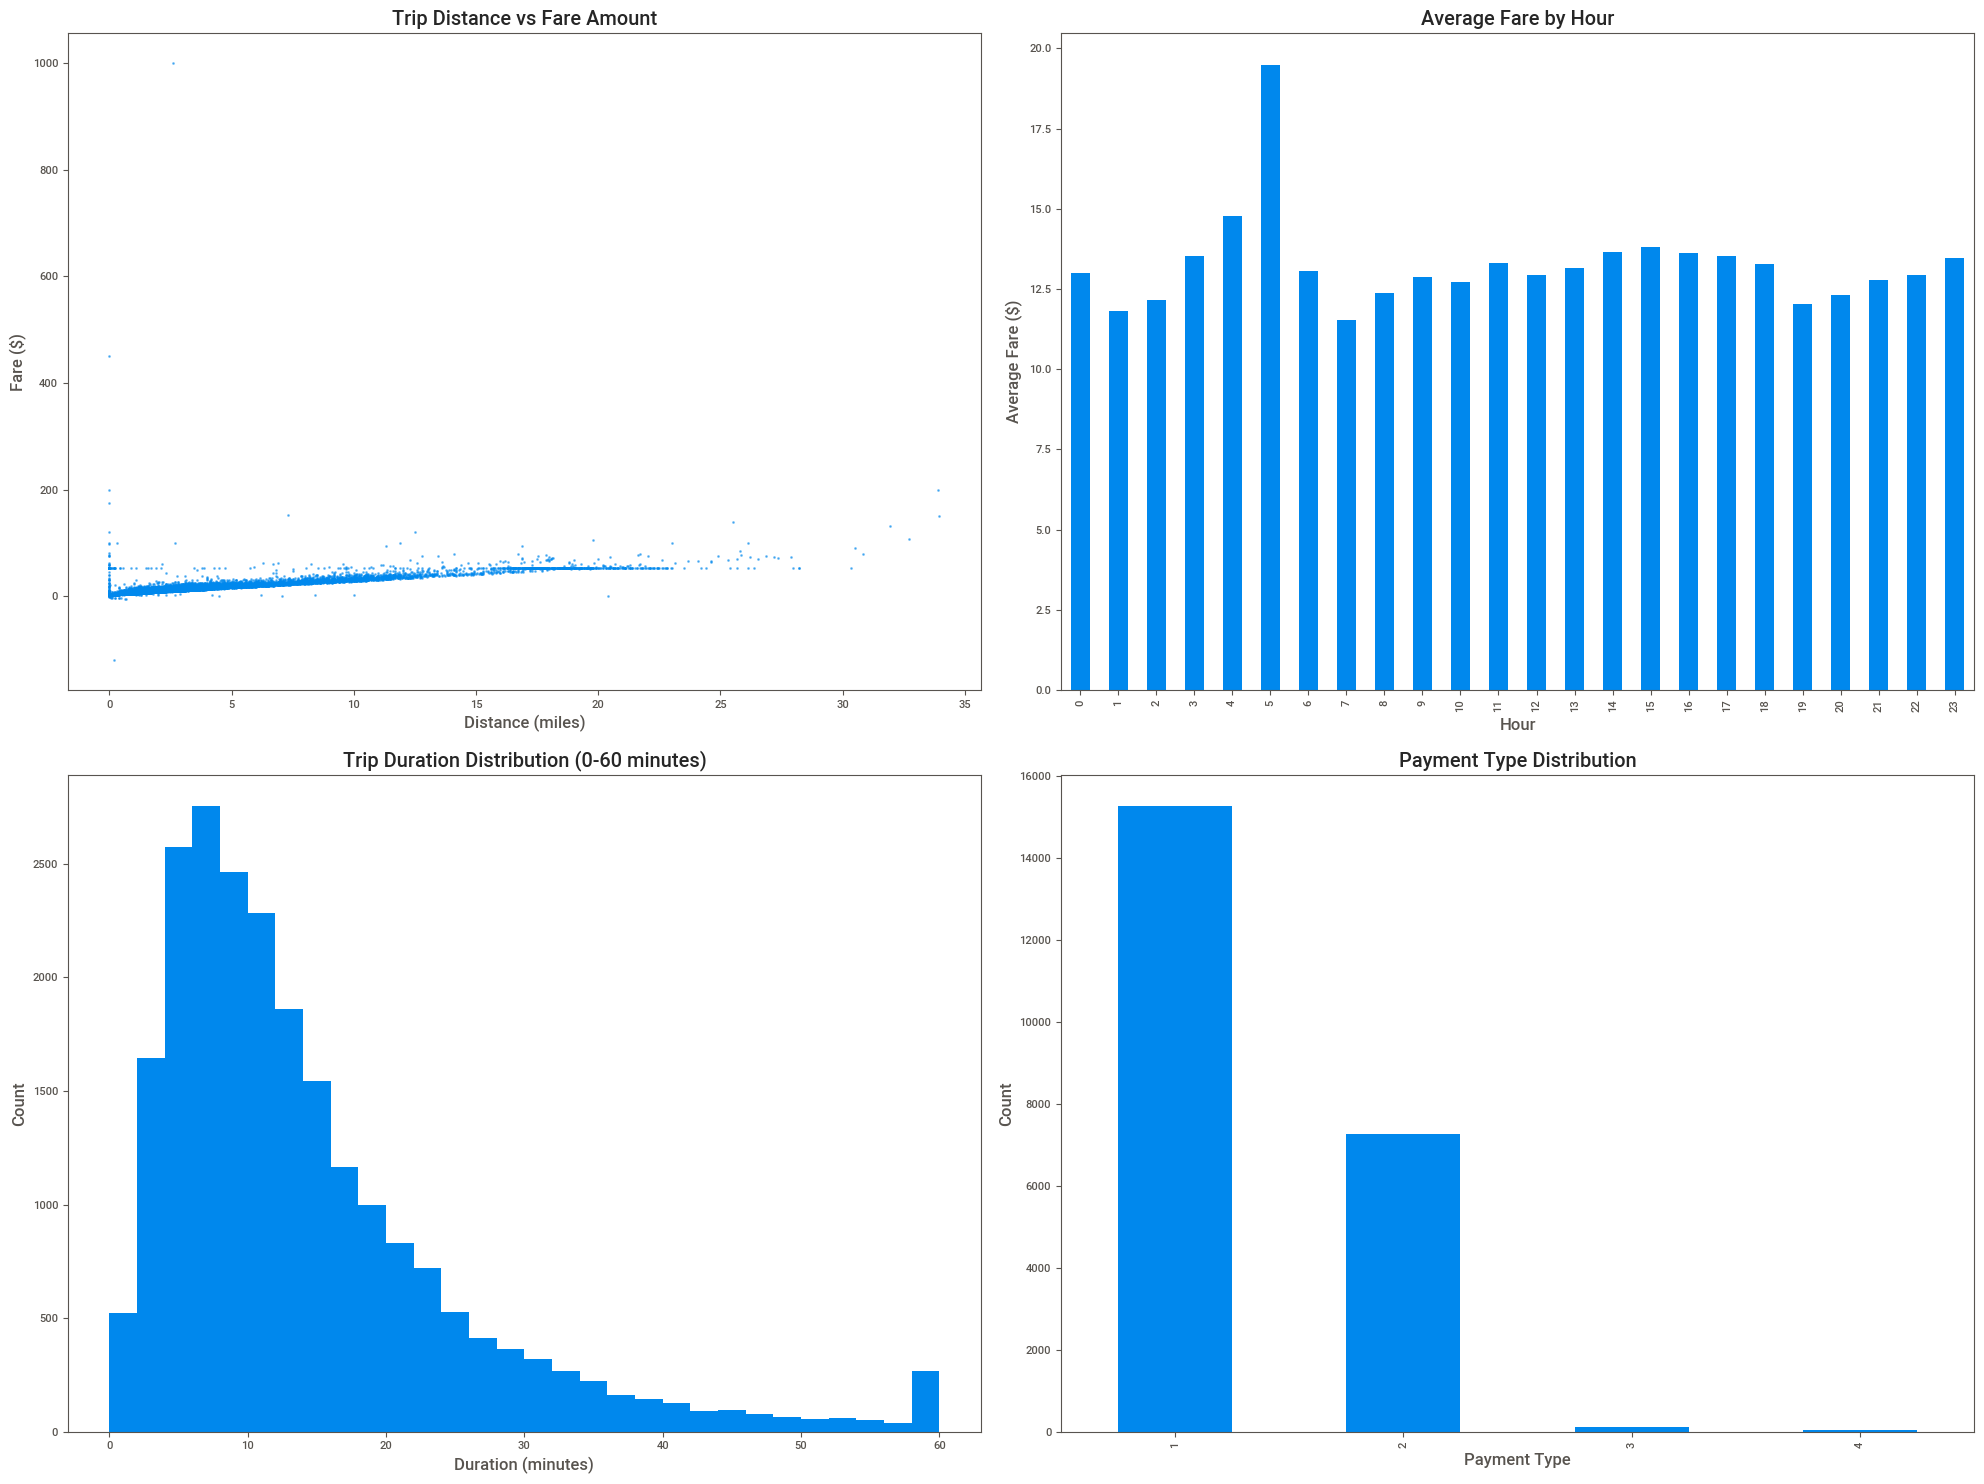

None


In [ ]:
def create_initial_visualizations(df):
    """
    Create initial visualization set
    """
    print("\nCreating initial visualizations...")

    # Set up the figure
    plt.figure(figsize=(20, 15))

    # 1. Trip distance vs fare amount
    plt.subplot(2, 2, 1)
    plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.5, s=1)
    plt.title('Trip Distance vs Fare Amount')
    plt.xlabel('Distance (miles)')
    plt.ylabel('Fare ($)')

    # 2. Average fare by hour
    plt.subplot(2, 2, 2)
    hourly_fares = df.groupby(df['tpep_pickup_datetime'].dt.hour)['fare_amount'].mean()
    hourly_fares.plot(kind='bar')
    plt.title('Average Fare by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Average Fare ($)')

    # 3. Trip duration distribution
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    plt.subplot(2, 2, 3)
    plt.hist(df['trip_duration'].clip(0, 60), bins=30)
    plt.title('Trip Duration Distribution (0-60 minutes)')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Count')

    # 4. Payment type distribution
    plt.subplot(2, 2, 4)
    df['payment_type'].value_counts().plot(kind='bar')
    plt.title('Payment Type Distribution')
    plt.xlabel('Payment Type')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Create visualizations
print(create_initial_visualizations(df))

# Data Preprocessing and Feature Engineering:

In [ ]:
def preprocess_data(df):
    """
    Comprehensive data preprocessing and feature engineering
    """
    print("\nStarting data preprocessing...")

    # Create a copy of the dataframe
    df_processed = df.copy()

    # 1. Calculate trip duration and speed
    df_processed['trip_duration'] = (df_processed['tpep_dropoff_datetime'] -
                                   df_processed['tpep_pickup_datetime']).dt.total_seconds() / 60
    df_processed['average_speed'] = np.where(
        df_processed['trip_duration'] > 0,
        df_processed['trip_distance'] / (df_processed['trip_duration'] / 60),
        0
    )

    # 2. Create time-based features
    df_processed['pickup_hour'] = df_processed['tpep_pickup_datetime'].dt.hour
    df_processed['pickup_day'] = df_processed['tpep_pickup_datetime'].dt.day
    df_processed['pickup_month'] = df_processed['tpep_pickup_datetime'].dt.month
    df_processed['pickup_dayofweek'] = df_processed['tpep_pickup_datetime'].dt.dayofweek
    df_processed['is_weekend'] = df_processed['pickup_dayofweek'].isin([5, 6]).astype(int)

    # 3. Remove obvious outliers
    print("Removing outliers...")

    # Remove negative values
    df_processed = df_processed[df_processed['trip_distance'] >= 0]
    df_processed = df_processed[df_processed['fare_amount'] >= 0]
    df_processed = df_processed[df_processed['trip_duration'] >= 0]

    # Remove extreme outliers using percentiles
    for col in ['trip_distance', 'fare_amount', 'trip_duration']:
        q1 = df_processed[col].quantile(0.01)
        q3 = df_processed[col].quantile(0.99)
        df_processed = df_processed[
            (df_processed[col] >= q1) &
            (df_processed[col] <= q3)
        ]

    # 4. Create additional features
    df_processed['fare_per_mile'] = np.where(
        df_processed['trip_distance'] > 0,
        df_processed['fare_amount'] / df_processed['trip_distance'],
        0
    )

    df_processed['fare_per_minute'] = np.where(
        df_processed['trip_duration'] > 0,
        df_processed['fare_amount'] / df_processed['trip_duration'],
        0
    )

    # 5. Encode categorical variables
    print("Encoding categorical variables...")
    le = LabelEncoder()
    categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']

    for col in categorical_cols:
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))

    # 6. Scale numerical features
    print("Scaling numerical features...")
    scaler = RobustScaler()
    numerical_cols = ['trip_distance', 'trip_duration', 'average_speed',
                     'fare_per_mile', 'fare_per_minute']

    df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

    print(f"\nShape after preprocessing: {df_processed.shape}")
    return df_processed

# Preprocess the data
df_preprocessed = preprocess_data(df)

# Display sample of processed data
print("\nSample of preprocessed data:")
print(df_preprocessed.head())
print("\nNew features created:", df_preprocessed.columns.tolist())


Starting data preprocessing...
Removing outliers...
Encoding categorical variables...
Scaling numerical features...

Shape after preprocessing: (21637, 31)

Sample of preprocessed data:
   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0    24870114      2    2017-03-25 08:55:43   2017-03-25 09:09:47    
1    35634249      1    2017-04-11 14:53:28   2017-04-11 15:19:58    
2   106203690      1    2017-12-15 07:26:56   2017-12-15 07:34:08    
3    38942136      2    2017-05-07 13:17:59   2017-05-07 13:48:14    
4    30841670      2    2017-04-15 23:32:20   2017-04-15 23:49:03    

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0         6           0.882653          1              N           
1         1           0.096939          1              N           
2         1          -0.311224          1              N           
3         1           1.066327          1              N           
4         1           1.408163          1           

# Clustering and Anomaly Detection:


Performing clustering and anomaly detection...


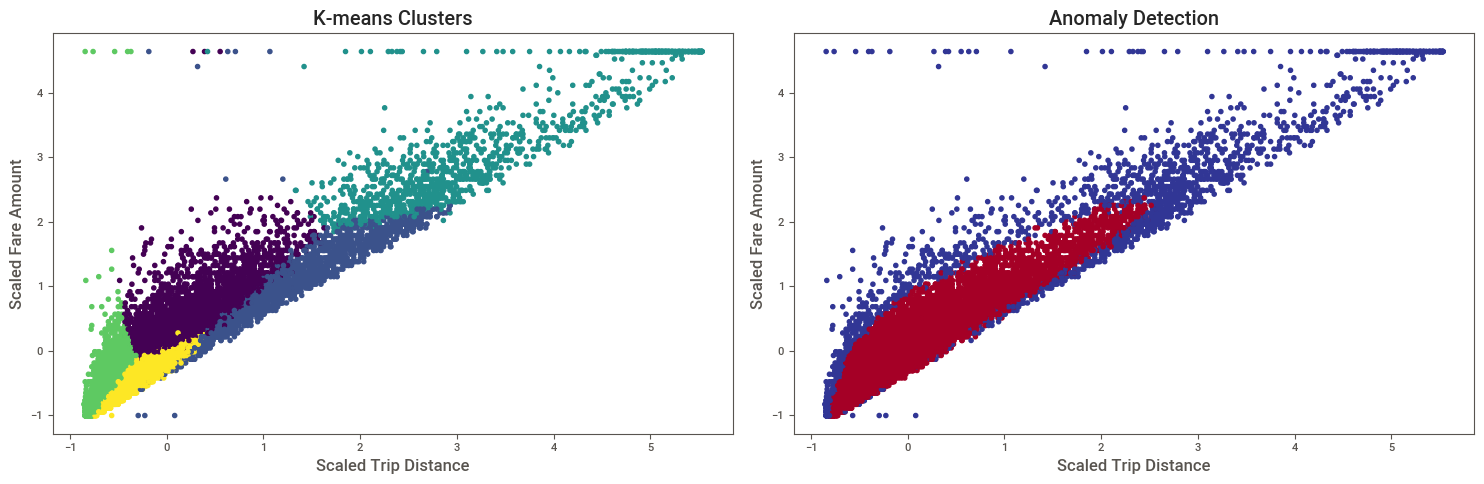

In [ ]:
def perform_clustering(df):
    """
    Perform clustering and anomaly detection
    """
    print("\nPerforming clustering and anomaly detection...")

    # Select features for clustering
    cluster_features = ['trip_distance', 'fare_amount', 'trip_duration',
                       'average_speed', 'fare_per_mile']
    X = df[cluster_features].copy()

    # Handle any remaining infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 1. K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # 2. Anomaly detection
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['is_anomaly'] = iso_forest.fit_predict(X_scaled)
    df['is_anomaly'] = df['is_anomaly'].map({1: 0, -1: 1})  # 1 for anomaly

    # Visualize clusters
    plt.figure(figsize=(15, 5))

    # Plot clusters
    plt.subplot(1, 2, 1)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['cluster'], cmap='viridis')
    plt.title('K-means Clusters')
    plt.xlabel('Scaled Trip Distance')
    plt.ylabel('Scaled Fare Amount')

    # Plot anomalies
    plt.subplot(1, 2, 2)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['is_anomaly'], cmap='RdYlBu')
    plt.title('Anomaly Detection')
    plt.xlabel('Scaled Trip Distance')
    plt.ylabel('Scaled Fare Amount')

    plt.tight_layout()
    plt.show()

    return df

# Perform clustering and anomaly detection
df_clustered = perform_clustering(df_preprocessed)

# Feature Selection and Preparation:

In [ ]:
def prepare_features(df):
    """
    Select and prepare features for modeling
    """
    print("\nPreparing features for modeling...")

    # Select features for modeling
    features = [
        'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_dayofweek',
        'average_speed', 'fare_per_mile', 'fare_per_minute', 'is_weekend',
        'VendorID_encoded', 'RatecodeID_encoded', 'payment_type_encoded',
        'cluster', 'is_anomaly'
    ]

    # Prepare X and y
    X = df[features]
    y = df['fare_amount']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature selection using SelectKBest
    selector = SelectKBest(score_func=f_regression, k=10)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get selected feature names
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    print("\nSelected features:", selected_features)

    return X_train_selected, X_test_selected, y_train, y_test, selected_features

# Prepare features
X_train, X_test, y_train, y_test, selected_features = prepare_features(df_clustered)


Preparing features for modeling...

Selected features: ['trip_distance', 'trip_duration', 'average_speed', 'fare_per_mile', 'fare_per_minute', 'is_weekend', 'RatecodeID_encoded', 'payment_type_encoded', 'cluster', 'is_anomaly']


# Build Multiple Models:

In [ ]:
def build_multiple_models(X_train, X_test, y_train, y_test):
    """
    Build and evaluate multiple models
    """
    print("\nBuilding and evaluating multiple models...")

    # Initialize models
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Ensemble': VotingRegressor([
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
        ])
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train,
                                  cv=5, scoring='neg_root_mean_squared_error')
        cv_rmse = -cv_scores

        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'cv_rmse_mean': cv_rmse.mean(),
            'cv_rmse_std': cv_rmse.std()
        }

        # Print results
        print(f"\n{name} Results:")
        print(f"Train RMSE: ${train_rmse:.2f}")
        print(f"Test RMSE: ${test_rmse:.2f}")
        print(f"Test R² Score: {test_r2:.3f}")
        print(f"CV RMSE: ${cv_rmse.mean():.2f} ± ${cv_rmse.std():.2f}")

    return results

# Build and evaluate models
model_results = build_multiple_models(X_train, X_test, y_train, y_test)
def build_multiple_models(X_train, X_test, y_train, y_test):
    """
    Build and evaluate multiple models
    """
    print("\nBuilding and evaluating multiple models...")

    # Initialize models
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Ensemble': VotingRegressor([
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
        ])
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train,
                                  cv=5, scoring='neg_root_mean_squared_error')
        cv_rmse = -cv_scores

        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'cv_rmse_mean': cv_rmse.mean(),
            'cv_rmse_std': cv_rmse.std()
        }

        # Print results
        print(f"\n{name} Results:")
        print(f"Train RMSE: ${train_rmse:.2f}")
        print(f"Test RMSE: ${test_rmse:.2f}")
        print(f"Test R² Score: {test_r2:.3f}")
        print(f"CV RMSE: ${cv_rmse.mean():.2f} ± ${cv_rmse.std():.2f}")

    return results

# Build and evaluate models
model_results = build_multiple_models(X_train, X_test, y_train, y_test)


Building and evaluating multiple models...

Training RandomForest...

RandomForest Results:
Train RMSE: $0.22
Test RMSE: $0.34
Test R² Score: 0.999
CV RMSE: $0.63 ± $0.28

Training GradientBoosting...

GradientBoosting Results:
Train RMSE: $0.44
Test RMSE: $0.51
Test R² Score: 0.997
CV RMSE: $0.59 ± $0.13

Training Ensemble...

Ensemble Results:
Train RMSE: $0.27
Test RMSE: $0.37
Test R² Score: 0.998
CV RMSE: $0.54 ± $0.20

Building and evaluating multiple models...

Training RandomForest...

RandomForest Results:
Train RMSE: $0.22
Test RMSE: $0.34
Test R² Score: 0.999
CV RMSE: $0.63 ± $0.28

Training GradientBoosting...

GradientBoosting Results:
Train RMSE: $0.44
Test RMSE: $0.51
Test R² Score: 0.997
CV RMSE: $0.59 ± $0.13

Training Ensemble...

Ensemble Results:
Train RMSE: $0.27
Test RMSE: $0.37
Test R² Score: 0.998
CV RMSE: $0.54 ± $0.20


# Visualize Model Performance and Feature Importance:


Creating model performance visualizations...


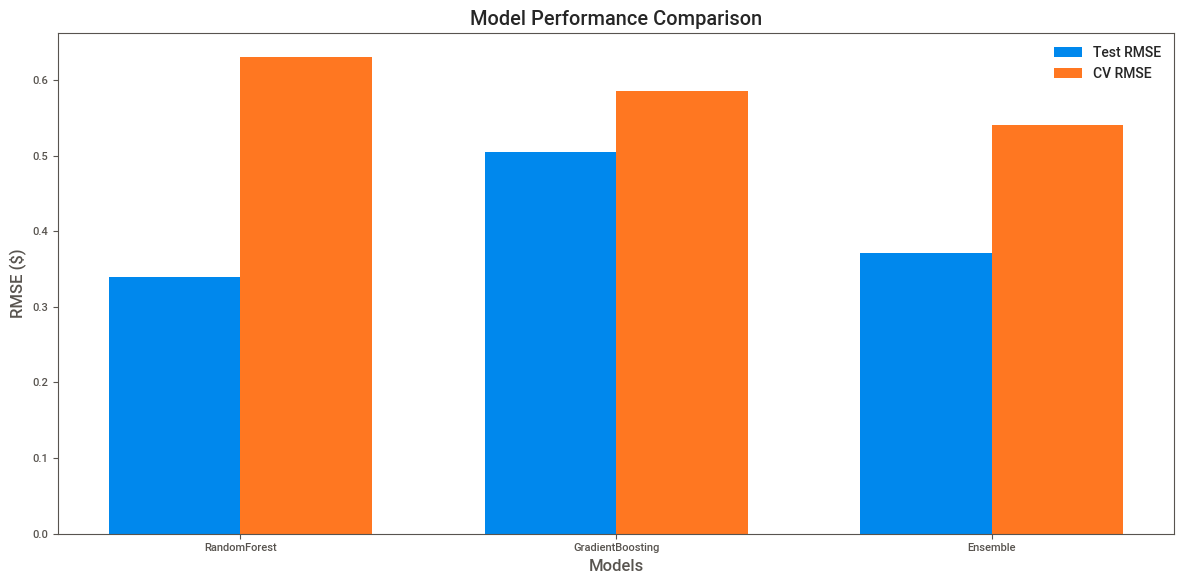


Final Model Performance Summary:
--------------------------------------------------

RandomForest:
Test RMSE: $0.34
CV RMSE: $0.63 ± $0.28
R² Score: 0.999

GradientBoosting:
Test RMSE: $0.51
CV RMSE: $0.59 ± $0.13
R² Score: 0.997

Ensemble:
Test RMSE: $0.37
CV RMSE: $0.54 ± $0.20
R² Score: 0.998
None


In [ ]:
def visualize_model_performance(model_results):
    """
    Visualize model performance comparisons
    """
    print("\nCreating model performance visualizations...")

    # Prepare data for plotting
    models = list(model_results.keys())
    test_rmse = [results['test_rmse'] for results in model_results.values()]
    cv_rmse = [results['cv_rmse_mean'] for results in model_results.values()]

    # Create bar plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, test_rmse, width, label='Test RMSE')
    plt.bar(x + width/2, cv_rmse, width, label='CV RMSE')

    plt.xlabel('Models')
    plt.ylabel('RMSE ($)')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\nFinal Model Performance Summary:")
    print("-" * 50)
    for name, results in model_results.items():
        print(f"\n{name}:")
        print(f"Test RMSE: ${results['test_rmse']:.2f}")
        print(f"CV RMSE: ${results['cv_rmse_mean']:.2f} ± ${results['cv_rmse_std']:.2f}")
        print(f"R² Score: {results['test_r2']:.3f}")

# Visualize model performance
print(visualize_model_performance(model_results))

# Save Best Model and Make Predictions:


Best performing model: RandomForest


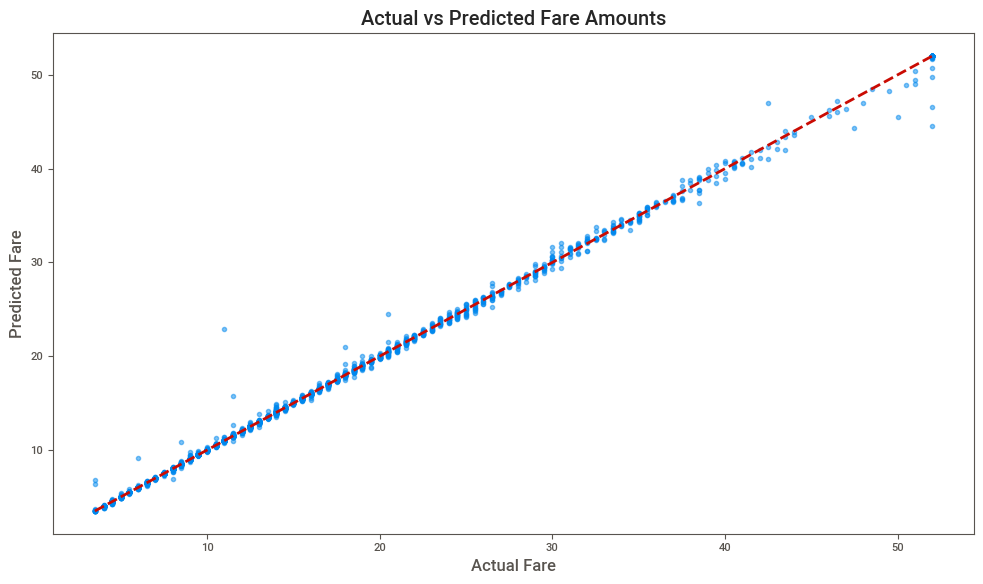


Sample Predictions vs Actual Values:
Actual: $6.00, Predicted: $6.00
Actual: $8.00, Predicted: $8.04
Actual: $9.00, Predicted: $9.00
Actual: $5.00, Predicted: $5.07
Actual: $10.50, Predicted: $10.51


In [ ]:
def save_and_test_model(model_results, X_test, y_test):
    """
    Save the best model and make sample predictions
    """
    # Find the best model based on test RMSE
    best_model_name = min(model_results.items(),
                         key=lambda x: x[1]['test_rmse'])[0]
    best_model = model_results[best_model_name]['model']

    print(f"\nBest performing model: {best_model_name}")

    # Make predictions on test set
    y_pred = best_model.predict(X_test)

    # Create prediction vs actual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title('Actual vs Predicted Fare Amounts')
    plt.tight_layout()
    plt.show()

    # Print sample predictions
    print("\nSample Predictions vs Actual Values:")
    sample_idx = np.random.choice(len(y_test), 5)
    for idx in sample_idx:
        print(f"Actual: ${y_test.iloc[idx]:.2f}, Predicted: ${y_pred[idx]:.2f}")

    return best_model

# Save and test the best model
best_model = save_and_test_model(model_results, X_test, y_test)

# Install Additional Packages:

In [ ]:
!pip install ydata-profiling sweetviz autoviz pycaret dtale

# Import Libraries with AutoML:

In [ ]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import dtale
from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

# Automated EDA:

In [ ]:
def perform_automated_eda_simple(df):
    """
    Perform automated EDA using YData Profiling and Sweetviz
    """
    print("Performing automated EDA...")

    # 1. YData Profiling
    print("\nGenerating YData Profiling Report...")
    profile = ProfileReport(df, title="Taxi Data Analysis Report", minimal=True)
    profile.to_file("taxi_profiling_report.html")

    # 2. Sweetviz Analysis
    print("\nGenerating Sweetviz Report...")
    sweet_report = sv.analyze(df)
    sweet_report.show_html('taxi_sweetviz_report.html')

    # Basic statistics and information
    print("\nBasic Dataset Information:")
    print("-" * 50)
    print("\nShape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nNumerical Statistics:\n", df.describe())

    return profile, sweet_report

# Load data and perform automated EDA
print("Loading data...")
df = pd.read_csv('/content/2017_Yellow_Taxi_Trip_Data (1).csv',
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# Perform automated EDA
auto_eda_results = perform_automated_eda_simple(df)

Loading data...
Performing automated EDA...

Generating YData Profiling Report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


Generating Sweetviz Report...


                                             |          | [  0%]   00:00 -> (? left)

Report taxi_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.

Basic Dataset Information:
--------------------------------------------------

Shape: (22699, 18)

Columns: ['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

Missing Values:
 Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
to

# Manual Insights from Automated EDA:

In [ ]:
def extract_manual_insights(df):
    """
    Extract and print manual insights from the data
    """
    print("\nExtracting key insights from the data:")
    print("-" * 50)

    # 1. Trip Statistics
    print("\nTrip Statistics:")
    print(f"Average trip distance: {df['trip_distance'].mean():.2f} miles")
    print(f"Average fare amount: ${df['fare_amount'].mean():.2f}")

    # 2. Temporal Patterns
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    hourly_trips = df.groupby('hour').size()
    peak_hour = hourly_trips.idxmax()
    print(f"\nPeak hour for trips: {peak_hour}:00")

    # 3. Payment Patterns
    payment_distribution = df['payment_type'].value_counts(normalize=True)
    print("\nPayment Type Distribution:")
    print(payment_distribution)

    # 4. Distance-Fare Correlation
    correlation = df['trip_distance'].corr(df['fare_amount'])
    print(f"\nCorrelation between distance and fare: {correlation:.3f}")

    # 5. Trip Duration Analysis
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    print(f"\nAverage trip duration: {df['trip_duration'].mean():.2f} minutes")

    return df

# Extract manual insights
df_with_insights = extract_manual_insights(df)


Extracting key insights from the data:
--------------------------------------------------

Trip Statistics:
Average trip distance: 2.91 miles
Average fare amount: $13.03

Peak hour for trips: 19:00

Payment Type Distribution:
payment_type
1    0.672497
2    0.320146
3    0.005331
4    0.002027
Name: proportion, dtype: float64

Correlation between distance and fare: 0.757

Average trip duration: 17.01 minutes


# AutoML with PyCaret:

In [ ]:
# First, install the correct version of PyCaret
!pip install --upgrade pycaret scikit-learn

import numpy as np
import pandas as pd
from pycaret.regression import *

def prepare_data_for_automl(df):
    """
    Prepare data for AutoML with proper scaling
    """
    print("Preparing data for AutoML...")

    # Create a copy of the dataframe
    df_model = df.copy()

    # Create time-based features
    df_model['pickup_hour'] = df_model['tpep_pickup_datetime'].dt.hour
    df_model['pickup_dayofweek'] = df_model['tpep_pickup_datetime'].dt.dayofweek
    df_model['pickup_month'] = df_model['tpep_pickup_datetime'].dt.month

    # Calculate trip duration in minutes (as float32 for better numerical stability)
    df_model['trip_duration'] = ((df_model['tpep_dropoff_datetime'] -
                                df_model['tpep_pickup_datetime']).dt.total_seconds() / 60).astype('float32')

    # Select and rename features
    df_model = df_model[[
        'fare_amount',
        'trip_distance',
        'passenger_count',
        'payment_type',
        'RatecodeID',
        'pickup_hour',
        'pickup_dayofweek',
        'pickup_month',
        'trip_duration'
    ]].copy()

    # Convert numerical columns to float32 for better stability
    float_columns = ['fare_amount', 'trip_distance', 'trip_duration']
    for col in float_columns:
        df_model[col] = df_model[col].astype('float32')

    # Basic cleaning
    df_model = df_model[df_model['trip_distance'] >= 0]
    df_model = df_model[df_model['fare_amount'] > 0]
    df_model = df_model[df_model['trip_duration'] > 0]

    # Remove outliers
    for col in ['trip_distance', 'fare_amount', 'trip_duration']:
        Q1 = df_model[col].quantile(0.01)
        Q3 = df_model[col].quantile(0.99)
        df_model = df_model[(df_model[col] >= Q1) & (df_model[col] <= Q3)]

    return df_model

def run_automl(data):
    """
    Run AutoML pipeline
    """
    print("Setting up AutoML environment...")

    # Initialize setup
    s = setup(data=data,
              target='fare_amount',
              train_size=0.8,
              categorical_features=['payment_type', 'RatecodeID'],
              numeric_features=['trip_distance', 'passenger_count', 'pickup_hour',
                              'pickup_dayofweek', 'pickup_month', 'trip_duration'],
              fold=5,
              session_id=42,
              preprocess=True,
              feature_selection=True)

    print("\nComparing models...")

    # Compare models
    best_model = compare_models(n_select=3)

    print("\nTuning top models...")

    # Tune top 3 models
    tuned_models = []
    for model in best_model:
        tuned = tune_model(model, n_iter=10)
        tuned_models.append(tuned)

    print("\nCreating ensemble model...")

    # Create ensemble
    ensemble = blend_models(tuned_models)

    print("\nFinalizing model...")

    # Finalize model
    final_model = finalize_model(ensemble)

    return final_model, tuned_models

def evaluate_and_interpret(model, data):
    """
    Evaluate model and create interpretability plots
    """
    print("\nCreating model evaluation plots...")

    # Create evaluation plots
    plot_model(model, plot='feature')
    plot_model(model, plot='error')
    plot_model(model, plot='residuals')

    # Get feature importance
    print("\nFeature Importance:")
    importance = get_feature_importance(model)
    print(importance)

    return importance

# Main execution
print("Starting taxi fare prediction AutoML pipeline...")

# Prepare data
df_prepared = prepare_data_for_automl(df)
print("\nPrepared data shape:", df_prepared.shape)

try:
    # Run AutoML
    final_model, tuned_models = run_automl(df_prepared)

    # Evaluate models
    importance = evaluate_and_interpret(final_model, df_prepared)

    # Get the best model's predictions
    predictions = predict_model(final_model)

    print("\nFinal Model Performance Metrics:")
    print(pull())

    # Save the model
    save_model(final_model, 'taxi_fare_predictor')
    print("\nModel saved as 'taxi_fare_predictor'")

except Exception as e:
    print(f"\nError during AutoML process: {str(e)}")

    # If error occurs, print detailed information
    print("\nDataset Information:")
    print(df_prepared.info())
    print("\nSample Data:")
    print(df_prepared.head())
    print("\nNumerical Statistics:")
    print(df_prepared.describe())

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Starting taxi fare prediction AutoML pipeline...
Preparing data for AutoML...

Prepared data shape: (21632, 9)
Setting up AutoML environment...

Error during AutoML process: underflow encountered in cast

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 21632 entries, 0 to 22698
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fare_amount       21632 non-null  float32
 1   trip_distance     21632 non-null  float32
 2   passenger_count   21632 non-null  int64  
 3   payment_type      21632 non-null  int64  
 4   RatecodeID        21632 non-null  int64  
 5   pickup_hour       21632 non-null  int32  
 6   pickup_dayofweek  21632 non-null  int32  
 7   pickup_month      21632 non-null  int32  
 8   trip_duration     21632 non-null  float32
dtypes: float32(3), int32(3), int64(3)
memor